# Spherical Gaussian experiment (2D)

## Setup

In [1]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging

sys.path.append("../../")

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Load results

In [2]:
algo_filenames = ["flow", "pie", "mf"]
algo_labels = ["Standard flow", "PIE", "Manifold flow"]

setup_filenames = [
    "10_15_0.010",
    "10_15_0.001",
    "10_15_0.003",
    "10_15_0.030",
    "10_15_0.100",
    "10_11_0.010",
    "10_13_0.010",
    "10_20_0.010",
    "10_30_0.010",
]


In [11]:
result_dir = "../data/results"

x_gen = []
logp_gen = []
distance_gen = []

for algo_filename in algo_filenames:
    x_gen_ = []
    logp_gen_ = []
    distance_gen_ = []
    for setup_filename in setup_filenames:
        try:
            x_gen_.append(np.load(
                "{}/{}_10_spherical_gaussian_{}_samples.npy".format(result_dir, algo_filename, setup_filename)
            ))
        except FileNotFoundError as e:
            print(e)
            x_gen_.append(None)
            
        try:
            logp_gen_.append(np.load(
                "{}/{}_10_spherical_gaussian_{}_samples_likelihood.npy".format(result_dir, algo_filename, setup_filename)
            ))
        except:
            logp_gen_.append(np.nan*np.ones(1000))
            
        try:
            distance_gen_.append(np.load(
                "{}/{}_10_spherical_gaussian_{}_samples_manifold_distance.npy".format(result_dir, algo_filename, setup_filename)
            ))
        except:
            distance_gen_.append(np.nan*np.ones(1000))
            
    x_gen.append(x_gen_)
    logp_gen.append(logp_gen_)
    distance_gen.append(distance_gen_)
    
logp_gen = np.asarray(logp_gen)
distance_gen = np.asarray(distance_gen)


(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
[Errno 2] No such file or directory: '../data/results/pie_10_spherical_gaussian_10_15_0.001_samples.npy'
[Errno 2] No such file or directory: '../data/results/pie_10_spherical_gaussian_10_15_0.003_samples.npy'
[Errno 2] No such file or directory: '../data/results/pie_10_spherical_gaussian_10_15_0.030_samples.npy'
[Errno 2] No such file or directory: '../data/results/pie_10_spherical_gaussian_10_15_0.100_samples.npy'
[Errno 2] No such file or directory: '../data/results/pie_10_spherical_gaussian_10_11_0.010_samples.npy'
[Errno 2] No such file or directory: '../data/results/pie_10_spherical_gaussian_10_13_0.010_samples.npy'
[Errno 2] No such file or directory: '../data/results/pie_10_spherical_gaussian_10_20_0.010_samples.npy'
[Errno 2] No such file or directory: '../data/results/pie_10_spherical_gaussian_10_30_0.010_samples.npy'
[Errno 2] No such file or directory: '../data/results/mf_10_spherical_gaussian_1

In [15]:
min_logp = -1000.

mean_logp_gen = np.mean(np.clip(logp_gen), min_logp, None), axis=2)
mean_distance_gen = np.mean(distance_gen, axis=2)


TypeError: nan_to_num() got an unexpected keyword argument 'nan'

## Plot results

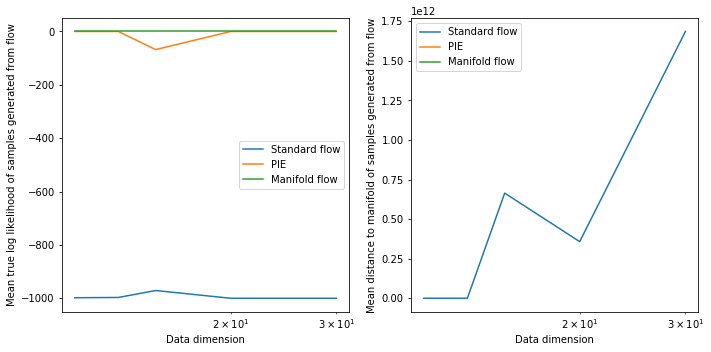

In [13]:
show = [5, 6, 0, 7, 8]
xs = [11, 13, 15, 20, 30]

fig = plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)
for mean_logp_gen_, algo_label in zip(mean_logp_gen, algo_labels):
    plt.plot(xs, mean_logp_gen_[show], label=algo_label)
plt.legend()
plt.xscale("log")
plt.xlabel("Data dimension")
plt.ylabel("Mean true log likelihood of samples generated from flow")

ax = plt.subplot(1,2,2)
for mean_distance_gen_, algo_label in zip(mean_distance_gen, algo_labels):
    plt.plot(xs, mean_distance_gen_[show], label=algo_label)
plt.legend()
plt.xscale("log")
plt.xlabel("Data dimension")
plt.ylabel("Mean distance to manifold of samples generated from flow")

plt.tight_layout()
plt.show()
